Loading the model and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- CONFIGURATION ---
DATA_PATH = "../data/processed/final_training_data.csv"
MODEL_PATH = "../models/heat_risk_model.pkl"

print(" Loading Data and Model...")

# 1. Load Data
df = pd.read_csv(DATA_PATH)
df['time'] = pd.to_datetime(df['time'])

# 2. Re-create the Test Split 
SPLIT_DATE = '2023-01-01'
test_df = df[df['time'] >= SPLIT_DATE].copy()

# 3. Define Features (Must match the columns used in Notebook 04)
features = [
    'population_2020', 'pop_log', 
    'temp_c', 'humidity_relative', 'wind_speed_m_s', 'solar_w_m2',
    'temp_roll_24h', 'hi_max_72h', 'risk_lag_1h'
]
target = 'risk_score'

X_test = test_df[features]
y_test = test_df[target]

# 4. Load Model
try:
    model = joblib.load(MODEL_PATH)
    print(f" Model Loaded: {type(model).__name__}")
except FileNotFoundError:
    print(" Model not found! Error in downloading model")

 Loading Data and Model...
 Model Loaded: XGBClassifier


Overall Performance 

In [2]:
print(" Running inference on Test Set (2023-2024)...")
y_pred = model.predict(X_test)

# --- 2. CLASSIFICATION REPORT ---
class_names = ['Safe', 'Caution', 'Danger', 'Extreme']

print("\n Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Calculate overall accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {acc:.2%}")

 Running inference on Test Set (2023-2024)...

 Classification Report:
              precision    recall  f1-score   support

        Safe       1.00      1.00      1.00    445680
     Caution       0.99      0.99      0.99    230682
      Danger       0.98      0.99      0.98    354558
     Extreme       0.97      0.96      0.96    111000

    accuracy                           0.99   1141920
   macro avg       0.99      0.98      0.98   1141920
weighted avg       0.99      0.99      0.99   1141920

Overall Accuracy: 98.93%


Confusion Matrix

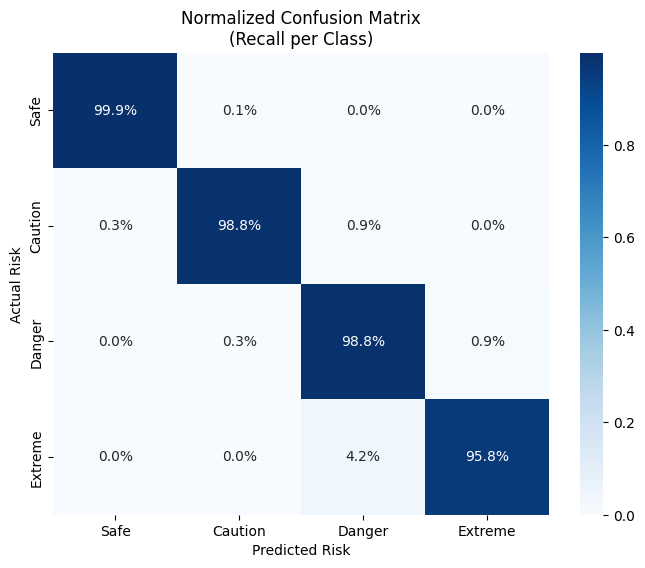

Interpretation Guide:
- Diagonal values (e.g., 98%) are correct predictions.
- Off-diagonal values are errors.
- CRITICAL CHECK: Look at the bottom-left corner. Is 'Extreme' ever predicted as 'Safe'?


In [3]:
cm = confusion_matrix(y_test, y_pred)

# Normalized by row (True Class) to see percentages
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt='.1%', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title("Normalized Confusion Matrix\n(Recall per Class)")
plt.xlabel("Predicted Risk")
plt.ylabel("Actual Risk")
plt.show()

print("Interpretation Guide:")
print("- Diagonal values (e.g., 98%) are correct predictions.")
print("- Off-diagonal values are errors.")
print("- CRITICAL CHECK: Look at the bottom-left corner. Is 'Extreme' ever predicted as 'Safe'?")

Error Analysis

In [4]:
#  ERROR ANALYSIS: INSPECTING FAILURES ---
test_df['predicted_risk'] = y_pred

# Filter for WRONG predictions
errors = test_df[test_df['risk_score'] != test_df['predicted_risk']].copy()
errors['error_magnitude'] = abs(errors['risk_score'] - errors['predicted_risk'])

print(f"Total Errors: {len(errors):,} out of {len(test_df):,} test rows")
print(f"Error Rate: {len(errors)/len(test_df):.2%}")


critical_mask = (errors['risk_score'] >= 2) & (errors['predicted_risk'] == 0)
critical_fails = errors[critical_mask]

if not critical_fails.empty:
    print(f"\n CRITICAL SAFETY FAILURES FOUND: {len(critical_fails)} rows")
    display(critical_fails[['time', 'district_name', 'temp_c', 'risk_score', 'predicted_risk']].head())
else:
    print("\n PASSED: No Critical Safety Failures (No Extreme events were missed as Safe).")

# B. BORDERLINE ERRORS (Off by 1)
# Actual = 2, Predicted = 1 (or vice versa)
borderline_mask = errors['error_magnitude'] == 1
print(f"\nBorderline Errors (Acceptable noise): {borderline_mask.sum()}")

Total Errors: 12,224 out of 1,141,920 test rows
Error Rate: 1.07%

 PASSED: No Critical Safety Failures (No Extreme events were missed as Safe).

Borderline Errors (Acceptable noise): 12224


Temporal Analysis

C:\Users\Rayyan Tech\AppData\Local\Temp\ipykernel_14508\2594719592.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=errors, x='month', order=month_order, palette='Reds')


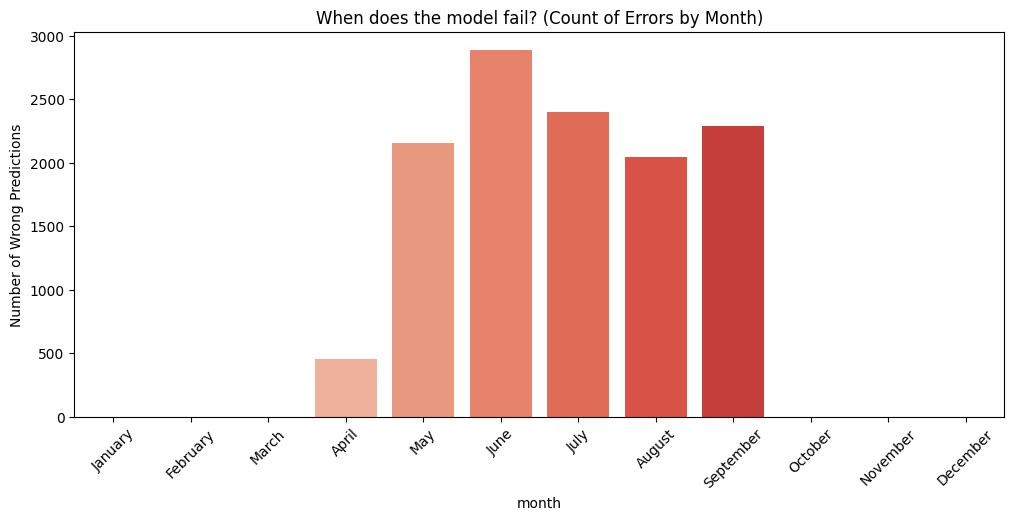

Analysis Tip: If errors spike in April/May, the model struggles with the onset of summer.


In [ ]:
# TEMPORAL ERROR DISTRIBUTION ---

# Extract month from the error rows
errors['month'] = errors['time'].dt.month_name()
# Sort order
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(12, 5))
sns.countplot(data=errors, x='month', order=month_order, palette='Reds')
plt.title("When does the model fail? (Count of Errors by Month)")
plt.xticks(rotation=45)
plt.ylabel("Number of Wrong Predictions")
plt.show()


Spatial Analysis

C:\Users\Rayyan Tech\AppData\Local\Temp\ipykernel_14508\3228809305.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_error_districts.values, y=top_error_districts.index, palette='magma')


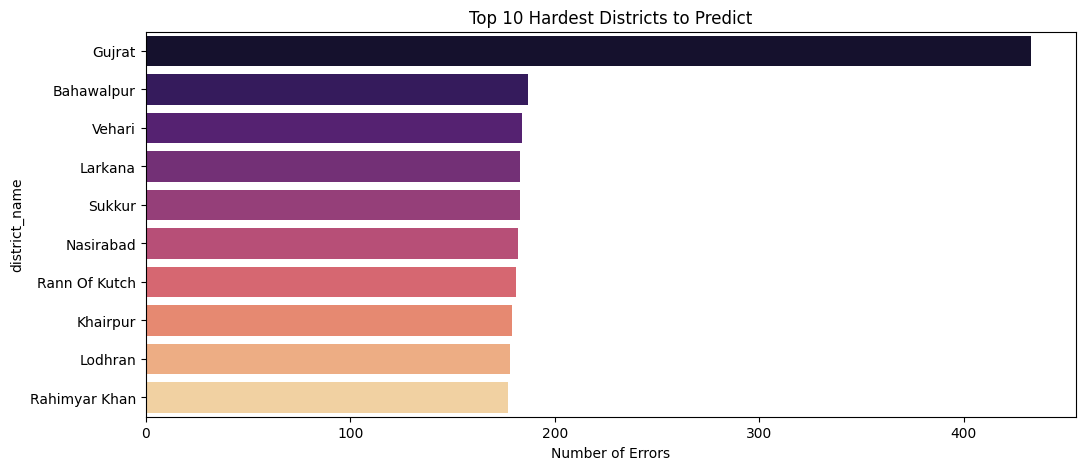

Analysis Tip: Are these districts mountainous (variable weather) or coastal?


In [ ]:
# SPATIAL ERROR DISTRIBUTION ---

# Top 10 Districts with the most errors
top_error_districts = errors['district_name'].value_counts().head(10)

plt.figure(figsize=(12, 5))
sns.barplot(x=top_error_districts.values, y=top_error_districts.index, palette='magma')
plt.title("Top 10 Hardest Districts to Predict")
plt.xlabel("Number of Errors")
plt.show()


External Validation with EMDAT

In [15]:
#  EXTERNAL VALIDATION WITH EM-DAT ---
EMDAT_FILE = "../data/raw/emdat/emdat_verification_data.xlsx"

print("Loading Historical Disaster Data...")

try:
    # 1. Load the file
    # We try Excel first, then CSV
    if EMDAT_FILE.endswith('.xlsx'):
        heatwaves = pd.read_excel(EMDAT_FILE)
    else:
        heatwaves = pd.read_csv(EMDAT_FILE)

    print(f"   Raw Rows Loaded: {len(heatwaves)}")

    # 2. Fix Dates (The Critical Step)
    # EM-DAT splits dates into separate columns (Start Year, Start Month, etc.)
    # We must combine them into a Python datetime object.
    
    # Fill missing days with defaults (1st of month for start, 28th for end)
    # This prevents errors if the exact day wasn't recorded
    heatwaves['Start Day'] = heatwaves['Start Day'].fillna(1).astype(int)
    heatwaves['End Day'] = heatwaves['End Day'].fillna(28).astype(int)
    
    # Create 'start_date' column
    heatwaves['start_date'] = pd.to_datetime(dict(
        year=heatwaves['Start Year'], 
        month=heatwaves['Start Month'], 
        day=heatwaves['Start Day']
    ))
    
    # Create 'end_date' column
    heatwaves['end_date'] = pd.to_datetime(dict(
        year=heatwaves['End Year'], 
        month=heatwaves['End Month'], 
        day=heatwaves['End Day']
    ))
    
    print(f" Successfully processed {len(heatwaves)} heatwave events.")
    
    # 3. Show the Table (For your Report)
    # We select only the columns that matter for validation
    display_cols = ['Location', 'start_date', 'end_date', 'Total Deaths', 'Total Affected']
    # Check if columns exist before selecting (EM-DAT format changes slightly sometimes)
    available_cols = [c for c in display_cols if c in heatwaves.columns]
    
    display(heatwaves[available_cols].sort_values('start_date'))

except Exception as e:
    print(f" Error: {e}")
    print("   Tip: Check the filename in EMDAT_FILE variable.")
    print("   Tip: Ensure the file is inside 'data/raw/emdat/' folder.")

Loading Historical Disaster Data...
   Raw Rows Loaded: 12
 Successfully processed 12 heatwave events.


,Location,start_date,end_date,Total Deaths,Total Affected
2,Punjab province,2000-06-01,2000-06-28,24.0,NaN
0,"Balochistan, Punjab, Sindh provinces",2002-05-01,2002-05-28,113.0,24.0
9,Punjab province,2003-05-01,2003-06-06,200.0,NaN
1,"Punjab, Sindh, Balochistan provinces",2005-06-13,2005-06-28,106.0,200.0
6,"Punjab, Sindh, Balotchistan provinces",2006-05-01,2006-05-28,84.0,100.0
10,"Mithi, Chachro, Dahli, Diplo, Islamkot, Nagarp...",2014-01-01,2014-04-30,139.0,NaN
3,"Sindh, Punjab provinces",2015-06-18,2015-06-24,1229.0,80000.0
11,Karachi,2018-05-18,2018-05-22,180.0,NaN
5,NaN,2022-03-01,2022-04-28,NaN,NaN
4,NaN,2023-04-01,2023-05-28,22.0,NaN


Karachi 2015 CaseStudy

Analyzing Model Behavior during 2015-06-15 to 2015-06-30 in Karachi West...


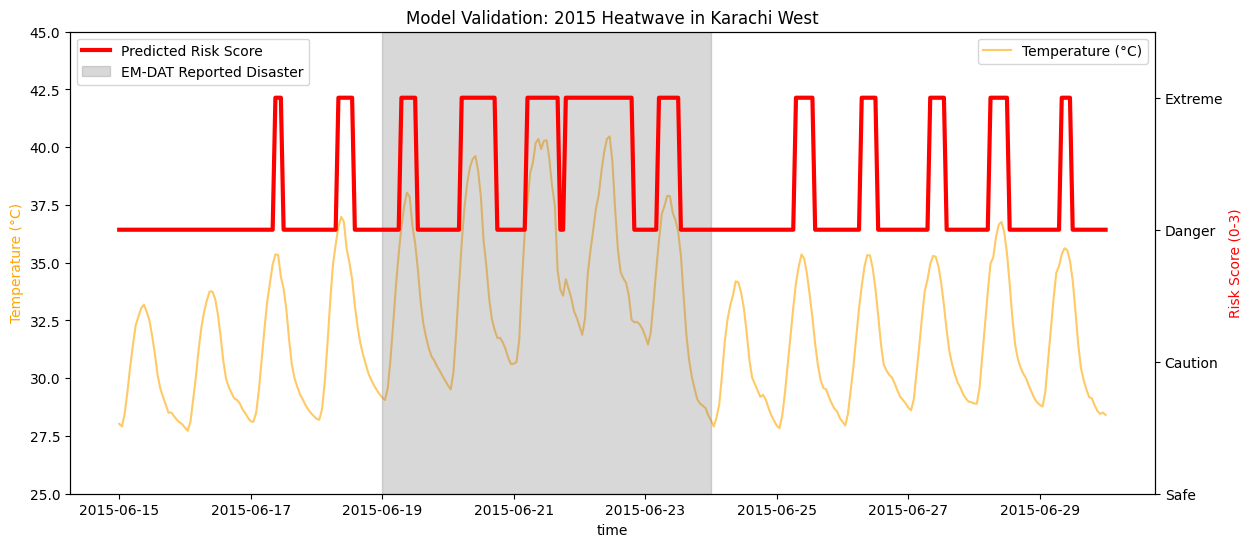

In [14]:
# VALIDATING THE 2015 KARACHI HEATWAVE ---

# 1. Select the Event (June 2015)
event_start = "2015-06-15"
event_end = "2015-06-30"
target_city = "Karachi West" # Or 'Karachi', depending on your standardized names

print(f"Analyzing Model Behavior during {event_start} to {event_end} in {target_city}...")

# 2. Get Model Predictions for this period
# We use the full dataset (df) here to access 2015 data
case_study_data = df[
    (df['district_name'] == target_city) & 
    (df['time'] >= event_start) & 
    (df['time'] <= event_end)
].copy()

if case_study_data.empty:
    print(f" No data found for {target_city}. Checking available districts...")
    print(df[df['district_name'].str.contains("Karachi")]['district_name'].unique())
else:
    # Running Inference (using the features the model expects)
    X_case = case_study_data[features]
    case_study_data['predicted_risk'] = model.predict(X_case)

    # 3. Plotting
    fig, ax1 = plt.subplots(figsize=(14, 6))

    # Plotting Temperature (Context)
    sns.lineplot(data=case_study_data, x='time', y='temp_c', ax=ax1, color='orange', label='Temperature (°C)', alpha=0.6)
    ax1.set_ylabel("Temperature (°C)", color='orange')
    ax1.set_ylim(25, 45)

    # Plotting Risk Score (The Prediction)
    ax2 = ax1.twinx()
    sns.lineplot(data=case_study_data, x='time', y='predicted_risk', ax=ax2, color='red', linewidth=3, label='Predicted Risk Score')
    ax2.set_ylabel("Risk Score (0-3)", color='red')
    ax2.set_ylim(0, 3.5)
    ax2.set_yticks([0, 1, 2, 3])
    ax2.set_yticklabels(['Safe', 'Caution', 'Danger', 'Extreme'])

    # Highlighting the Official EM-DAT Window
    plt.axvspan(pd.Timestamp('2015-06-19'), pd.Timestamp('2015-06-24'), color='grey', alpha=0.3, label="EM-DAT Reported Disaster")

    plt.title(f"Model Validation: 2015 Heatwave in {target_city}")
    plt.legend(loc='upper left')
    plt.show()
